In [50]:
%load_ext autoreload
%autoreload 2

import os, sys, glob
import re
import rdata
from nilearn import datasets, plotting
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

from matplotlib.pyplot import cm
import sklearn.cluster as sc
from sklearn.decomposition import PCA

os.getcwd()

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

import mcmc_fsv as fsv

nchan = 264
nfac = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_factor_by_subject(lam_stat, task_labels, factor_id = 0):
    ntask = len(task_labels)
    nfac = lam_stat.shape[1]
    vbnd = np.max(np.abs(lam_stat.flatten()))
    
    fig, axs = plt.subplots(ntask)
    for i in range(ntask):
        ltmp = lam_stat[:, factor_id, i]
        fsv.subplot_markers(ltmp, fsv.coords, vbnd, fig, axs[i], 10, title = task_labels[i])

    return fig, axs

### Subject Information

In [3]:
dpath_info = os.path.join(fsv.dpath_root, "bicnet/info/hcp_subject_behavioral_info.csv")
info = pd.read_csv(dpath_info)
info = info[['Subject', 'Gender', 'Age']]

nsub = info.shape[0]
print("Total {} subjects in the HCP database.".format(nsub))
info.head()

Total 1113 subjects in the HCP database.


Subject Gender    Age
0   100206      M  26-30
1   100307      F  26-30
2   100408      M  31-35
3   100610      M  26-30
4   101006      F  31-35

In [4]:
fsv.task_list

['REST1',
 'REST2',
 'LANGUAGE',
 'GAMBLING',
 'EMOTION',
 'RELATIONAL',
 'SOCIAL',
 'MOTOR',
 'WM']

### Save as npz file

In [ ]:
outpath = os.path.join(fsv.dpath_root, "mcmc_fsv_facload")
if not os.path.exists(outpath):
    os.mkdir(outpath)

for sid in info.Subject:
    file_list = fsv.get_task_list(sid)
    print(">>> Subject {} has {} datasets: {}".format(sid, len(file_list), file_list))
    
    fname = "mcmc_f" + str(nfac) + "_facload_" + str(sid) + ".npz"
    fpath = os.path.join(fsv.dpath_root, "mcmc_fsv_facload", fname)
    
    if os.path.exists(os.path.join(fpath)):
        print("Output file already exists.")
        continue
    
    if len(file_list) > 0:
        print("Try to data as npz.")
        try:
            tlab, Lambda, Zmap = fsv.get_nonzero_facload(
                sid, nchan, nfac, trimmed = True, verbose = False)
            print(tlab)
            np.savez(
                fpath, 
                tlab = tlab, file_list = file_list, Lambda = Lambda, Zmap = Zmap)
            print("Success.")
        except:
            print("Failed to load data.")

In [ ]:
dpath_root = os.path.join(os.path.expanduser("~"), "Dropbox", "data")
dpath = os.path.join(dpath_root, "mcmc_fsv")
dfiles = glob.glob(dpath + "/*.rdata")
print(dfiles[0].split("_")[3])

files = os.listdir(fsv.dpath_data)
sid_list = [d.split("_")[3] for d in dfiles]
sid_list

### Test: Single Subject

In [60]:
in_type = "median"
nchan = 90

files = glob.glob(fsv.dpath_data + "/*" + in_type + ".rdata")
sid_list = [f.split("_")[3] for f in files]
sid_list = list(set(sid_list))
print("Number of Subjects: {}".format(len(sid_list)))
print(*sid_list)

sid = str(sid_list[0])
file_list = fsv.get_task_list(sid, in_type = in_type)
print("Subject {} has {} datasets: {}".format(sid, len(file_list), file_list))

Number of Subjects: 89
105115 104416 112516 100610 103010 108323 111514 101107 114419 108828 102715 121618 113619 105014 107321 114924 106824 109123 120515 105620 103111 106521 111009 106319 113215 117324 110411 115320 108020 121416 122620 108222 112920 117930 122822 107018 110613 113922 104012 111312 102008 110007 105923 111211 113316 102513 118831 118124 101915 115219 105216 102816 118528 103212 106016 116524 120717 103414 111413 117021 112112 101309 104820 101006 115825 117122 109325 109830 100307 102109 114217 102311 122317 121921 112314 103818 100408 115724 120212 111716 118225 119025 102614 103515 120111 108525 107725 107422 118932
Subject 105115 has 3 datasets: {'MOTOR', 'LANGUAGE', 'REST1'}


In [61]:
tlab, Lammap, Zmap = fsv.get_nonzero_facload(sid, nchan, nfac, in_type = in_type)

MCMC output of REST1 105115 doesn't exist.
MCMC output of REST2 105115 doesn't exist.
MCMC output of GAMBLING 105115 doesn't exist.
MCMC output of EMOTION 105115 doesn't exist.
MCMC output of RELATIONAL 105115 doesn't exist.
MCMC output of SOCIAL 105115 doesn't exist.
MCMC output of WM 105115 doesn't exist.


KeyError: 'output'

['RELATIONAL', 'SOCIAL']


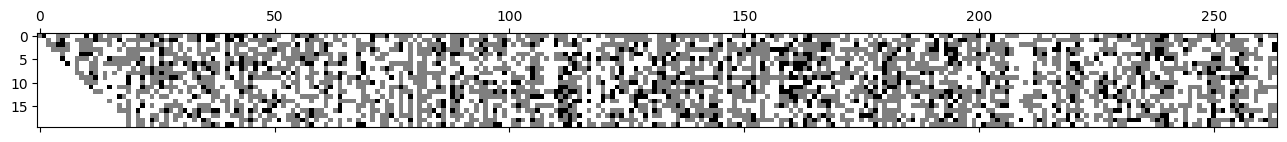

In [42]:
print(tlab)
plt.matshow(Zmap.T, vmin = 0, vmax = 1, cmap = cm.binary)

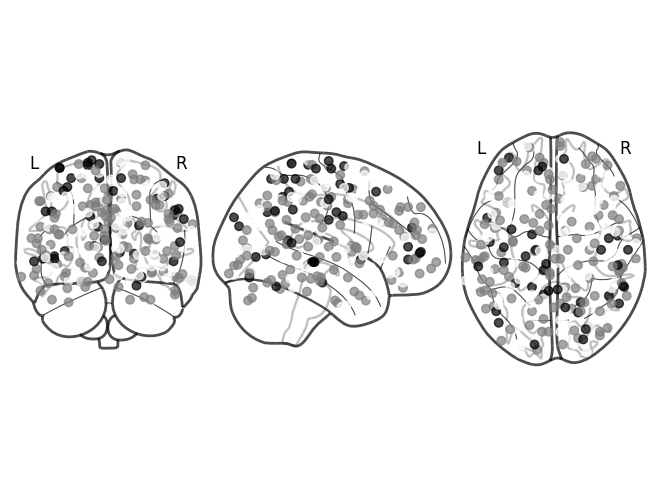

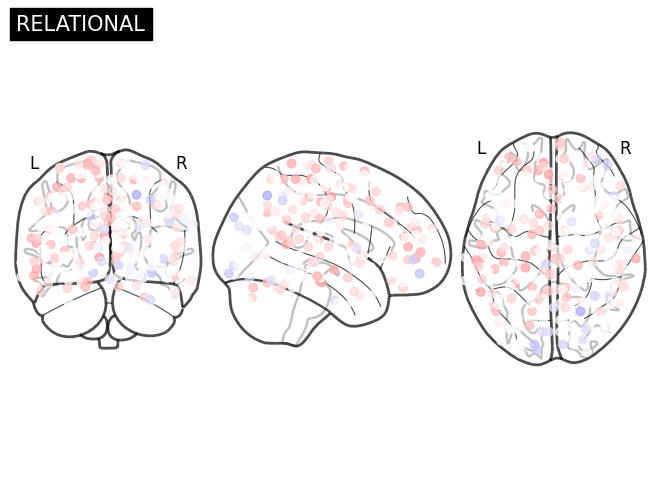

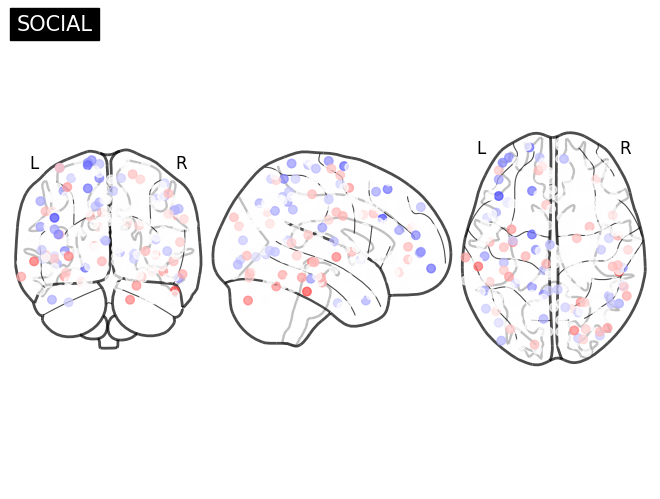

In [43]:
vbnd = np.max(np.abs(Lammap.flatten()))
ngrp = len(tlab)

k = 1
        
fig1 = plt.figure()
plotting.plot_markers(Zmap[:, k], fsv.coords, node_cmap = cm.binary, node_vmin = 0, node_vmax = 1, figure = fig1, colorbar=False, title=None)

for g in range(ngrp):
    fig2 = plt.figure()
    plotting.plot_markers(Lammap[:,k, g], fsv.coords, node_cmap = cm.bwr, node_vmin = -vbnd, node_vmax = vbnd, figure = fig2, colorbar=False, title=tlab[g])

In [ ]:
plt.rcParams["font.size"] = "4"

for id in sid_list:
    tlab, Lammap, Zmap = fsv.get_nonzero_facload(id, nchan, nfac)
    vbnd = np.max(np.abs(Lammap.flatten()))
    ngrp = len(tlab)
    
    for k in range(nfac):
        fn = "mcmc_f" + str(nfac) + "_f" + str(k) + "_" + str(id)
        
        fig1 = plt.figure()
        plotting.plot_markers(Zmap[:, k], fsv.coords, node_cmap = cm.binary, node_vmin = 0, node_vmax = 1, figure = fig1, colorbar=False, title=None)
        fn1 = os.path.join(fsv.dpath, "mcmc_fsv_markers", fn + "_1.png")
        fig1.savefig(fn1, dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        plt.close()
        
        if ngrp > 1:
            fig2, axs = plot_factor_by_subject(Lammap, tlab, k)
            fn2 = os.path.join(fsv.dpath, "mcmc_fsv_markers", fn + "_2.png")
        else:
            fig2 = plt.figure()
            plotting.plot_markers(Lammap[:,k, 0], fsv.coords, node_cmap = cm.bwr, node_vmin = -vbnd, node_vmax = vbnd, figure = fig2, colorbar=False, title=tlab[0])
            
        fig2.savefig(fn2, dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        plt.close()
        
        fig, (ax1, ax2) = plt.subplots(2)
        
        ax1.imshow(plt.imread(fn1))
        ax1.set_frame_on(False)
        ax1.axis('off')
        ax2.imshow(plt.imread(fn2))
        ax2.set_frame_on(False)
        ax2.axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)
        fig.savefig(os.path.join(fsv.dpath, "mcmc_fsv_markers", fn + ".png"), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        
        plt.close()
        os.remove(fn1)
        os.remove(fn2)
        
        
        

### Analyze Factor Loading Matrices

In [4]:
fpath = os.path.join(fsv.dpath_root, "mcmc_fsv_facload")
sid_list = os.listdir(fpath)
sid_list = [sfile.split(".")[0].split("_")[-1] for sfile in sid_list]
print(len(sid_list))
print(*sid_list, sep=" ")

99
899885 896778 937160 912447 927359 970764 983773 910443 105620  910241 100610 947668 942658 102614 987074 101309 926862 902242 996782 101915 901038 102513 887373 891667 951457 878776 888678 904044 993675 104820 100307 957974 901139 908860 880157 917558 962058 987983 102311 104012 991267 104416 102715 943862 106016 989987 882161 994273 101006 105923 885975 905147 889579 105115 922854 971160 992774 102109 894067 966975 978578 103818 911849 103414 930449 103010 959574 103212 923755 969476 990366 901442 894673 919966 884064 896879 894774 102008 105014 100408 105216 955465 933253 106319 965771 952863 102816 979984 958976 101107 992673 917255 878877 103515 103111 965367 907656 898176


In [5]:
Zmap = np.zeros((264, 20, len(sid_list)))
Xmap = np.zeros((len(sid_list), 210))

Extra the lower triangular part of the subject-specific factor inclusion probability matrices, and concatenate them into a matrix, whose row represents a subject and a column represent a entry in its flattened lower triangular record.

File /Users/meinitang/Dropbox/data/mcmc_fsv_facload/mcmc_f20_facload_.npz doesn't exist.
(98, 210)

(98, 210)
-0.01840049499585437 0.09372808377765515 0.07917641850238369 -0.04300447394054316 0.01591220749456401 -0.02293527142597685 -0.005352366314205248 0.033968616865359694 -0.058094321769526946 0.06392321757853733 -0.005776726046737794 -0.02756140580002833 -0.10613374065978479 0.05779768453593973 0.019645513199540148 -0.037127402756931736 0.026695300987990323 0.0677689520886999 -0.07250025964657483 -0.10282667905953292 -0.04651424339946747 -0.01570140233561199 -0.016102809168365765 0.1333423898924628 -0.10800848299130417 -0.12445177662516407 -0.0067707977841149096 -0.027551068852854965 -0.0720153192051467 0.06257322483603403 0.06667889831815436 0.010568591562537977 0.015019943509872522 -0.07193616598617622 -0.02684348074163726 -0.11516214929376169 0.023134416644548936 0.019715655048087387 0.057432326938323265 -0.0678493535022565 0.025853584757534877 -0.0302345443352591 0.029300272825

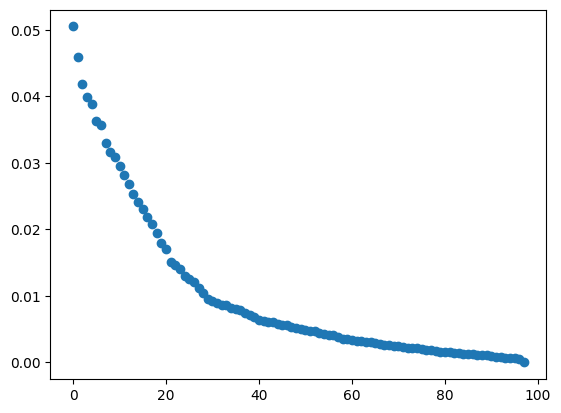

In [6]:
# for i in range(Zmap.shape[2]):
cnt = 0
for i in range(len(sid_list)):
    fname = "mcmc_f" + str(nfac) + "_facload_" + str(sid_list[i]) + ".npz"
    fpath = os.path.join(fsv.dpath_root, "mcmc_fsv_facload", fname)
    if os.path.exists(fpath):
        sdata = np.load(fpath)
        tmp = sdata['Zmap']
        Zmap[:,:,cnt] = tmp
        # print(Zmap[:5,:5,cnt])
        Xmap[cnt,:] = tmp[np.tril_indices(tmp.shape[1])] # flattened lower triangular part of factor loadings
        cnt += 1
    else:
        print("File {} doesn't exist.".format(fpath))



Xmap = Xmap[:98,:]
print(Xmap.shape)
# print(Xmap[:,:5])
mod = PCA()
Xpca = mod.fit(Xmap)
print("")
print(Xpca.components_.shape)
print(*Xpca.components_[:,0], sep=" ")
print(*Xmap[:,0], sep="")
Xmap2 = Xpca.components_[:, :20]
print(Xmap2[:5, :5])

Xstat = np.zeros((98,2))
Xstat[:,1] = Xpca.explained_variance_ratio_
Xstat[:,0] = range(98)
plt.scatter(Xstat[:,0], Xstat[:,1])
plt.show()

55005350220000034331050132342400302252504351100130040330425010130343133311502230344132505335004351


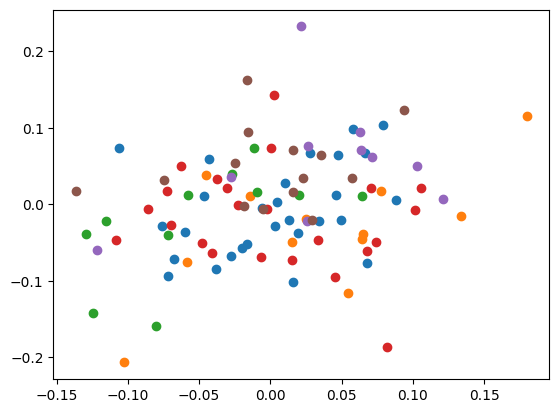

In [34]:
model = sc.AgglomerativeClustering(n_clusters = 6)
yhat = model.fit_predict(Xmap2)
clusters = np.unique(yhat)
print(*yhat, sep="")

clusters2 = sc.DBSCAN(eps = 1, min_samples = 2, metric = "l1").fit(Xmap2)
yhat2 = clusters2.labels_ + 1
clusters2 = np.unique(yhat2)

for c in clusters:
    rid = np.where(yhat == c)
    plt.scatter(Xmap2[rid,0], Xmap2[rid,1])

plt.show()

In [ ]:
G = nx.cycle_graph(Xmap.shape[0])
pos = nx.spring_layout(G)
yhat_labels = { index[0]: v for index, v in np.ndenumerate(yhat2)}

nx.draw_circular(G)
pos = nx.layout.circular_layout(G)
nx.draw_networkx_labels(G, pos,yhat_labels)
nx.set_node_attributes(G, yhat2, "values")

G.nodes[0]




In [73]:
cls = np.unique(yhat2)
ncls = cls.shape[0]

known_colors = list(ig.drawing.colors.known_colors)
col_idx = np.random.randint(len(known_colors), size = ncls).astype(int)
col_palette = np.take(known_colors, col_idx)


yhat_cols = [ col_palette[y] for y in yhat2 ]

print(yhat_cols)

g = ig.Graph()
g.add_vertices(yhat2.shape[0]) # each node is a single subject
g.vs["color"] = yhat_cols
g.vs["label"] = np.arange(yhat2.shape[0])


['grey93', 'grey93', 'olivedrab4', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'chocolate2', 'chocolate2', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'grey93', 'palevioletred3', 'palevioletred3', 'palevioletred3', 'darkseagreen2', 'grey93', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'grey93', 'palevioletred3', 'grey65', 'grey93', 'olivedrab4', 'palevioletred3', 'grey93', 'grey93', 'grey65', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'palevioletred3', 'seashell4', 'grey93', 'grey93', 'gray34', 'grey93', 'grey93', 'grey93', 'grey93', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'palevioletred3', 'grey93', 'darkseagreen2', 'palevioletred3', 'grey93', 'grey93', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'grey93', 'grey93', 'palevioletred3', 'grey93', 'grey93', 'palevioletred3', 'darkseagreen2', 'palevioletred3', 'gray34', 'grey93', 'grey93', 'grey93', 'grey93', 'palevioletred3', 'grey93',

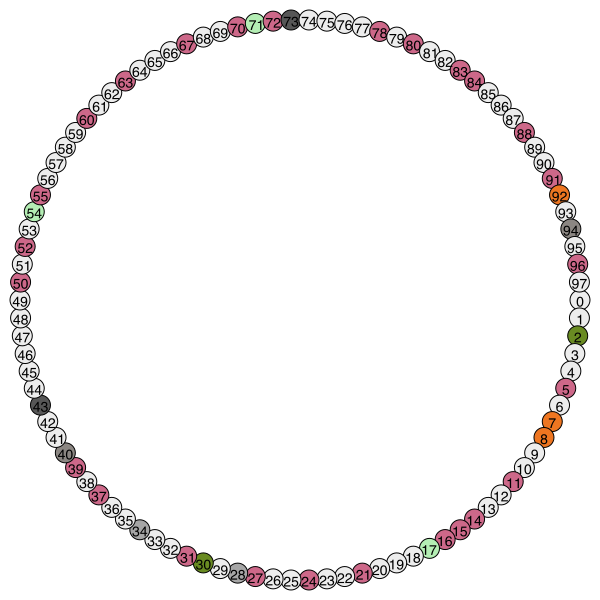

In [74]:
ig.plot(g, layout = g.layout("circle"))